# Comparison between observations and sea level projections 1

This notebook includes the results of AR6 and CMIP6 wich was not the case in the number 1

In [11]:
import sys
import importlib

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import IPython.display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

sys.path.append('/Users/dewilebars/Projects/SLBudget/code/')
import SeaLevelContrib as slc
sys.path.append('../code')
import func_postpro as postpro

In [12]:
importlib.reload(slc)
importlib.reload(postpro)

<module 'func_postpro' from '../code/func_postpro.py'>

In [184]:
path_fig = '/Users/dewilebars/Projects/KNMIClimateScenarios2021-2023/KNMI21/projections/figures/'

### Read tide gauge and projection data

In [15]:
tg_id = [20, 22, 23, 24, 25, 32]
tg_df = slc.tide_gauge_obs(tg_id, interp=True)
tg_df.iloc[-5:]

,20,22,23,24,25,32,Average
time,,,,,,,
2015,14.663924,18.510256,13.701935,19.948387,16.597419,14.80473,16.371109
2016,14.963924,18.710256,11.801935,16.448387,12.897419,14.10473,14.821109
2017,16.563924,20.910256,15.701935,22.248387,17.497419,17.10473,18.337775
2018,12.063924,15.110256,9.001935,12.548387,7.297419,10.30473,11.054442
2019,17.063924,21.410256,17.201935,21.548387,16.597419,14.40473,18.037775


<AxesSubplot:xlabel='time'>

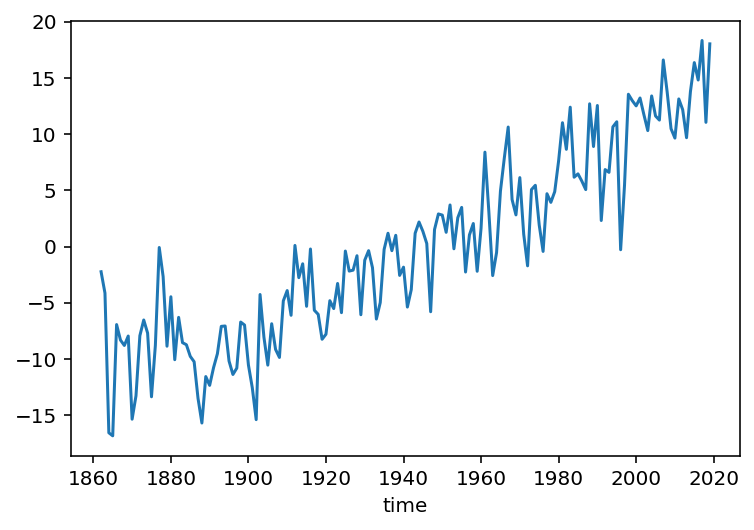

In [8]:
tg_df.Average.plot()

In [126]:
# Standard KNMI14 csv data file
KNMI14_df = postpro.read_knmi14(add_subsidence=True)
KNMI14_df[:5]

,low_05,low_95,high_05,high_95,low_05_sub,low_95_sub,high_05_sub,high_95_sub
year,,,,,,,,
1995,-0.2826,0.3990,-0.2826,0.3990,-0.2826,0.3990,-0.2826,0.3990
1996,0.1787,0.7226,0.1814,0.7251,0.2237,0.7676,0.2264,0.7701
1997,0.3832,1.3960,0.5654,1.5800,0.4732,1.4860,0.6554,1.6700
1998,0.5978,1.6610,0.9111,1.9760,0.7328,1.7960,1.0461,2.1110
1999,0.6499,2.0520,1.2050,2.6090,0.8299,2.2320,1.3850,2.7890


In [129]:
# KNMI14 projections including components info
# Info on the "level" index: 
# mean, p05, p10, p50, p90, p95, last column not used.
path_KNMI14 = '/Users/dewilebars/Projects/Project_ProbSLR/KNMI14/'
KNMI14_high_ds = xr.open_dataset(path_KNMI14 + 
                    '/ComponentInfo/ENS_knmi_NORTHSEA_slscen_high_V8.nc', 
                                 decode_times=False)
KNMI14_low_ds = xr.open_dataset(path_KNMI14 + 
                    '/ComponentInfo/ENS_knmi_NORTHSEA_slscen_low_V8.nc', 
                                decode_times=False)
KNMI14_high_ds['time'] = KNMI14_high_ds.time + 1950
KNMI14_low_ds['time'] = KNMI14_low_ds.time + 1950

In [130]:
def KNMI14_ds2df(ds,level=3):
    '''Extract the time series of contributors from a sea level projection 
    xarray dataset and build a pandas dataframe. Inputs are a dataset and 
    the percentile to extract.
    Info on the "level" index: 
    0:mean, 1:p05, 2:p10, 3:p50, 4:p90, 5:p95, 6:not used.
    '''
    variables = ['total', 'smb_gre', 'smb_aa', 'gic', 'ibe', 'steric', 
                 'dyn_gre', 'dyn_aa', 'groundw','tglob']
    
    df = pd.DataFrame()
    for idx, val in enumerate(variables):
        if val == 'tglob':
            df[val] = ds[val][:,0,0,0]
        else:
            df[val] = ds[val][:,level,0,0]*100 # Convert from m to cm

    df['time'] = ds.time
    df = df.set_index('time')
    return df

KNMI14_high_df = KNMI14_ds2df(KNMI14_high_ds, 3)
KNMI14_low_df = KNMI14_ds2df(KNMI14_low_ds, 3)

In [187]:
def read_proj(sce, name):
    '''Read projection data and add subsidence'''
    
    proj_data_dir = '../outputs/'
    proj_ds = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_{name}_{sce}.nc')
    subsidence = (np.arange(len(proj_ds.time))+10) * 0.045
    sub_2d = np.repeat(subsidence[:,np.newaxis], 
                       repeats=len(proj_ds.percentiles), axis=1)
    sub_2d = np.swapaxes(sub_2d,0,1)
    tot_sub = sub_2d+proj_ds.perc_ts.sel(proc='Total').values
    sub = np.concatenate([sub_2d[np.newaxis,:,:],  tot_sub[np.newaxis,:,:]],
                         axis=0)
    proj_sub = xr.DataArray(sub, dims=proj_ds.perc_ts.dims, 
                            coords=[['Subsidence', 'Total_with_sub'], 
                                    proj_ds.percentiles, proj_ds.time])
    proj_sub = xr.concat([proj_ds.perc_ts, proj_sub], dim='proc')
    
    return proj_sub

KNMIsig_sub = read_proj('ssp245', 'KNMIsignal')
KNMIsigBNW_sub = read_proj('ssp245', 'KNMIsignal_BiasCorr_NoWind')
KNMIsigBWW_sub = read_proj('ssp245', 'KNMIsignal_BiasCorr_WithWind')
KNMI14_sub = read_proj('rcp45', 'KNMI14')


### Comparison plots

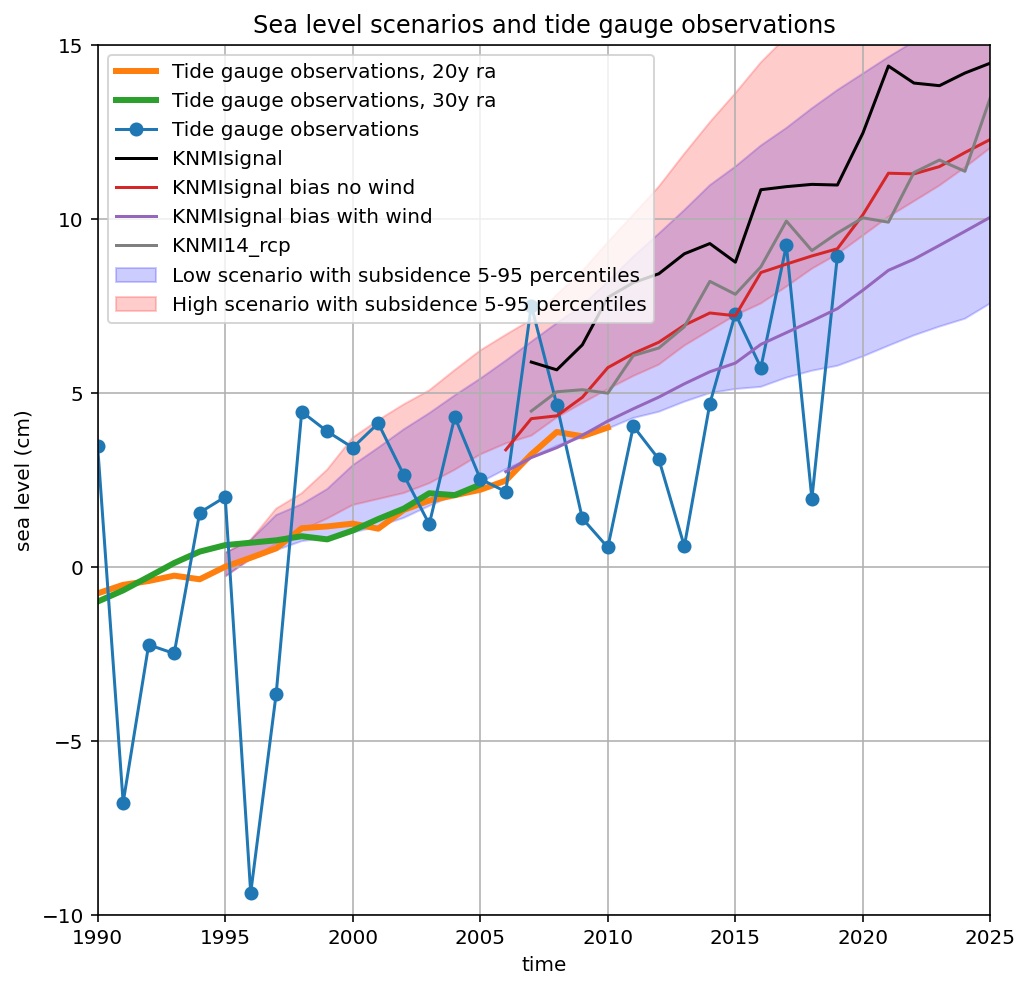

In [196]:
tg_avg_20ra = tg_df['Average'].rolling(20, center=True).mean()
tg_avg_30ra = tg_df['Average'].rolling(30, center=True).mean()
ref = tg_avg_20ra.loc[1995]

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'], 
                KNMI14_df['low_95_sub'], color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'], 
                KNMI14_df['high_95_sub'], color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_avg_20ra - ref, '-', color='tab:orange', label='Tide gauge observations, 20y ra', linewidth=3)
ax.plot(tg_avg_30ra - ref, '-', color='tab:green', label='Tide gauge observations, 30y ra', linewidth=3)
ax.plot(tg_df['Average'] - ref, 'o-', color='tab:blue', label='Tide gauge observations')

KNMIsig_sub.sel(proc='Total_with_sub', percentiles=[50]).plot(color='black', label='KNMIsignal')
KNMIsigBNW_sub.sel(proc='Total_with_sub', percentiles=[50]).plot(color='tab:red', label='KNMIsignal bias no wind')
KNMIsigBWW_sub.sel(proc='Total_with_sub', percentiles=[50]).plot(color='tab:purple', label='KNMIsignal bias with wind')
KNMI14_sub.sel(proc='Total_with_sub', percentiles=[50]).plot(color='grey', label='KNMI14_rcp')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2025])
ax.set_ylim([-10,15])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_fig+'comp_timeseris.pdf', dpi=150)

### Compare with a budget

In [124]:
path_slb = '/Users/dewilebars/Projects/SLBudget/outputs/'
budget_df = pd.read_csv(path_slb+
                        'slbudget_2020_12_03_ZSM_1979_2018_ERA5StericEN4_4000m.csv')
budget_df = budget_df.set_index('time')
budget_df.iloc[-10:]

,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
2009,8.016171,3.552064,2.508173,1.105000,1.194167,0.370833,0.088333,0.188333,0.892339,-1.090116,-0.792955,5.600000
2010,8.003000,4.389224,2.463398,1.141833,1.259167,0.446667,0.100833,0.367500,0.735257,-2.354945,-0.545934,4.766667
2011,9.988545,4.781370,2.577349,1.178667,1.286667,0.466667,0.103333,-0.016667,0.555900,1.935137,-2.879877,8.250000
2012,7.799622,2.654583,2.741227,1.215500,1.289167,0.491667,0.115833,0.316667,0.374518,0.184546,-1.584085,7.300000
2013,5.084063,3.520389,2.934533,1.252333,1.345833,0.561667,0.125000,0.511667,0.211591,-3.656733,-1.722219,4.800000
2014,8.918411,4.540554,3.090276,1.289167,1.401667,0.626667,0.130833,0.240000,0.085516,-2.865864,0.379595,8.900000
2015,10.947002,3.255820,3.297743,1.326000,1.474167,0.721667,0.144167,0.465000,0.010529,3.470097,-3.218186,11.483333
2016,7.910991,3.790802,3.270519,1.362833,1.528333,0.692500,0.157500,0.675000,-0.004905,-1.330948,-2.230644,9.933333
2017,13.661746,5.137556,3.428105,1.399667,1.600000,0.708333,0.165000,0.130833,0.040957,3.277656,-2.226363,13.450000


In [191]:
def comp_budget(KNMIsig_sub):
    '''Make a dataframe that can easily be used to make a bar chart'''

    sp = 2007
    ep = 2018
    ref_s = 1986
    ref_e = 2005
    tot_years = (sp+ep)/2 - (ref_e+ref_s)/2

    sce = 'low' # 'low' or 'high'
    if sce == 'low':
        KNMI14_sce = KNMI14_low_df
        rcp_scen = 'ssp245'
    elif sce == 'high':
        KNMI14_sce = KNMI14_high_df
        rcp_scen = 'ssp585'

    budget_diff = (budget_df.loc[sp:ep].mean() 
                   - budget_df.loc[ref_s:ref_e].mean())/tot_years*10
    KNMI14_sig_diff = KNMIsig_sub.sel(time=slice(sp,ep), percentiles=50
                                     ).mean(dim='time')/tot_years*10
    KNMI14_sce_diff = (KNMI14_sce.loc[sp:ep].mean() 
                       - KNMI14_sce.loc[ref_s:ref_e].mean())/tot_years*10

    budget_LocOcean = budget_diff['LocSteric'] + budget_diff['Nodal'] \
    + budget_diff['Wind'] +  budget_diff['Pressure']

    # Build a new dataframe for comparison purposes:
    index = ['Total', 'Ocean', 'Glaciers', 'Antarctica', 
             'Greenland', 'Land water', 'VLM']

    obs_budget = [budget_diff['Total'], budget_LocOcean + budget_diff['GloSteric'],
                  budget_diff['Glaciers'], budget_diff['Antarctica'], 
                  budget_diff['Greenland'], budget_diff['TWS'], budget_diff['GIA']]
    proj = [KNMI14_sig_diff.sel(proc='Total_with_sub').values.item(), 
            KNMI14_sig_diff.sel(proc='Local ocean').values.item() 
            + KNMI14_sig_diff.sel(proc='Global steric').values.item(), 
            KNMI14_sig_diff.sel(proc='Glaciers').values.item(),
            KNMI14_sig_diff.sel(proc='sum anta.').values.item(), 
            KNMI14_sig_diff.sel(proc='Greenland SMB').values.item() 
            + KNMI14_sig_diff.sel(proc='Greenland dynamics').values.item(),
            KNMI14_sig_diff.sel(proc='Landwater').values.item(),
            KNMI14_sig_diff.sel(proc='Subsidence').values.item()]
    sce_proj = [KNMI14_sce_diff['total'], KNMI14_sce_diff['steric'], 
                KNMI14_sce_diff['gic'], 
                KNMI14_sce_diff['smb_aa'] + KNMI14_sce_diff['dyn_aa'],
                KNMI14_sce_diff['smb_gre'] + KNMI14_sce_diff['dyn_gre'],
                KNMI14_sce_diff['groundw'], 0]
    comp_df = pd.DataFrame({'Budget': obs_budget,
                            rcp_scen: proj, 
                            'KNMI14 '+sce+' scenario': sce_proj},
                           index=index)
    return comp_df

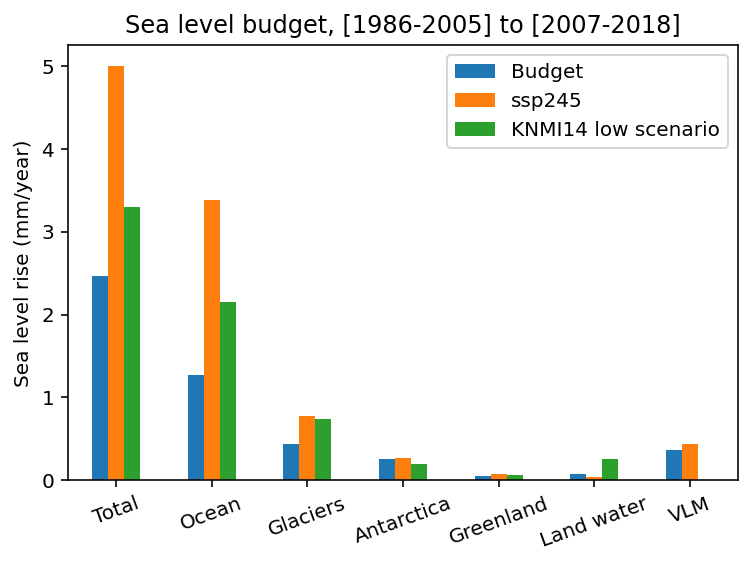

In [197]:
comp_df = comp_budget(KNMIsig_sub)
ax = comp_df.plot.bar(rot=20)
#ax.set_ylim([0,4.2])
plt.ylabel('Sea level rise (mm/year)')
plt.title('Sea level budget, ['+str(ref_s)+'-'+str(ref_e)+']'+' to ['+str(sp)+'-'+str(ep)+']' )

#plt.savefig(path_fig+'comp_budget_NoBiasCorr.pdf', dpi=150)

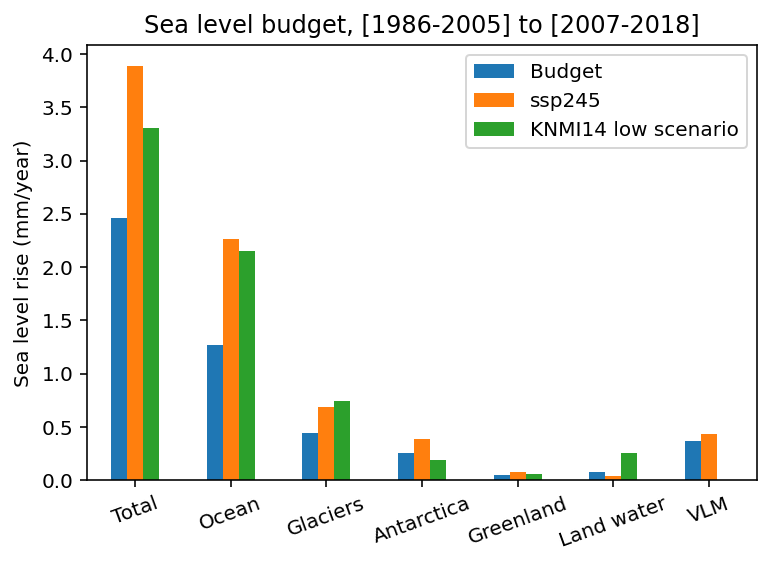

In [198]:
comp_df = comp_budget(KNMIsigBNW_sub)
ax = comp_df.plot.bar(rot=20)
#ax.set_ylim([0,4.2])
plt.ylabel('Sea level rise (mm/year)')
plt.title('Sea level budget, ['+str(ref_s)+'-'+str(ref_e)+']'+' to ['+str(sp)+'-'+str(ep)+']' )

#plt.savefig(path_fig+'comp_budget_BiasCorrNoWind.pdf', dpi=150)

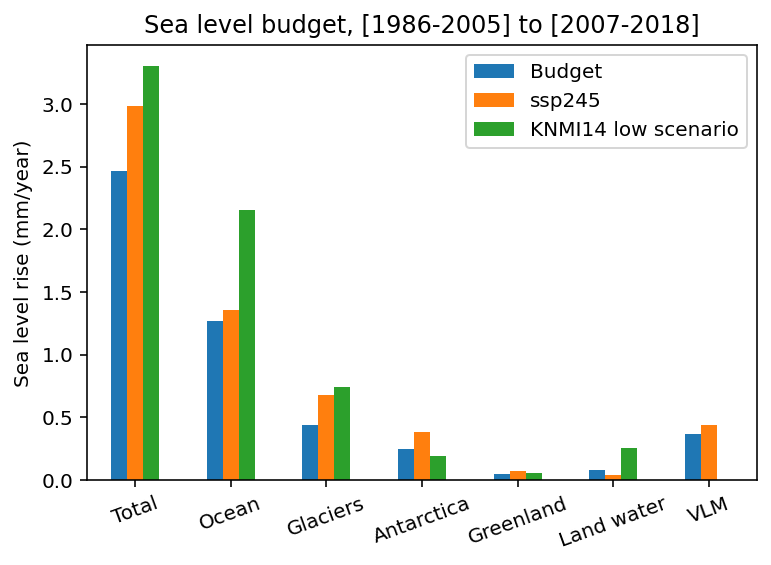

In [199]:
comp_df = comp_budget(KNMIsigBWW_sub)
ax = comp_df.plot.bar(rot=20)
#ax.set_ylim([0,4.2])
plt.ylabel('Sea level rise (mm/year)')
plt.title('Sea level budget, ['+str(ref_s)+'-'+str(ref_e)+']'+' to ['+str(sp)+'-'+str(ep)+']' )

#plt.savefig(path_fig+'comp_budget_BiasCorrWithWind.pdf', dpi=150)